### Downloading datasets:

1. download image sequences from: http://www.cvlibs.net/download.php?file=data_odometry_color.zip
2. download ground truth labels from: http://www.cvlibs.net/download.php?file=data_odometry_poses.zip
3. Unzip the downloaded contents in the 'path_to_dataset' folder

In [1]:
data_root='path_to_dataset\\'
best_wts_path='path_to_weights\\best_weight_PRF.hdf5'

In [2]:
img_root=data_root+'data_odometry_color\\dataset\\sequences\\'
label_root=data_root+'data_odometry_poses\\dataset\\poses\\'
seed=1
drop_seed=seed

In [3]:
## from __future__ import print_function
import os
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)
import tensorflow as tf
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(seed)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense ,Input,concatenate ,Conv2D,Conv2DTranspose,\
MaxPooling2D,AveragePooling2D, LSTM ,Reshape, TimeDistributed,ReLU, LeakyReLU, Dropout, BatchNormalization
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam,Adagrad
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K


import glob
import math
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import h5py
from collections import deque
from copy import copy,deepcopy
from tqdm import tqdm,trange
import time
import zlib

image_w= 320#448# 1280
image_h= 128#384
time_step=2
overlap=1
start_points=[0]#,2,4]
no_of_pose=6

#all_files=[0,1,2,3,4,5,6,7,8,9,10]
train_files=[0,1,2,3,6,8,9]
val_files = [5,7,10]#7,10]
test_files= [4,5,7,10]

#learning rate scheduling parameters
batch_size=16

scale=2
#label_scale='std_scl'
label_scale='diff_div'
#label_scale='diff_scl'
_img_norm=False
_img_offset=0.5
_keep_yaw_only=False
_flow_scale=2
_flow_format='hsv'
_flow_loss='rmsle'
_flow_chanel=2
_flow_decompress=False

_disp_or_seg='disp'
_pose_loss='mae'
_disp_scale=2
_disp_loss=_flow_loss
_disp_chanel=1

class Net_Params():
    def __init__(self,_scale):
        self.N=64//_scale
        N=self.N
        self._num_shared_layer=9
        
        self._kernels        =[7, 5,  5,  3,  3,  3,  3,  3,   3,    3]
        self._filters        =[N,2*N,4*N,4*N,8*N,8*N,8*N,8*N,16*N,16*N]
        self._strides        =[2, 2,  2,  1,  2,  1,  2,  1,   2,   1]
        self._block          =[1, 2,  3,  3,  4,  4,  5,  5,   6,   6]
        self._nconv          =[1, 1,  1,  2,  1,  2,  1,  2,   1,   2]
        self._act            =[1, 1,  1,  1,  1,  1,  1,  1,   1,   1]
        self._batch_norm     =[1, 1,  1,  1,  1,  1,  1,  1,   1,   1]
        self._drop_out       =[0, 0,  0,  0,  0,  0,  0,  0,   0,   0] 
        self._act[self._num_shared_layer-1]=0
        self._drop_out[self._num_shared_layer-1]=0.0
        
        
        
        
        self._num_trans_layers=2
        self._trans_layer_nodes  = [512,512,512]
        self._trans_act=[1,1,0]
        self._trans_drop_out=[0,0,0]
        
        self._num_rot_layers=2
        self._rot_layer_nodes = [512,512,512]
        self._rot_act=[1,1,0]
        self._rot_drop_out=[0,0,0]
        
        self.drop_seed       =seed
        self._leaky_relu     = True
        self._relu           = False
        self._kernel_initializer='he_normal'
        self._kernel_regularizer=None
        
        self._deconv_filters=[8*N,4*N,2*N,1*N]
        self._deconv_act =[1,1,1,1]
        self._flow_chanel =_flow_chanel
        self._disp_chanel =_disp_chanel
        
        
        
_net_par=Net_Params(scale)

In [4]:
_net_par.__dict__

{'N': 32,
 '_num_shared_layer': 9,
 '_kernels': [7, 5, 5, 3, 3, 3, 3, 3, 3, 3],
 '_filters': [32, 64, 128, 128, 256, 256, 256, 256, 512, 512],
 '_strides': [2, 2, 2, 1, 2, 1, 2, 1, 2, 1],
 '_block': [1, 2, 3, 3, 4, 4, 5, 5, 6, 6],
 '_nconv': [1, 1, 1, 2, 1, 2, 1, 2, 1, 2],
 '_act': [1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
 '_batch_norm': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 '_drop_out': [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0],
 '_num_trans_layers': 2,
 '_trans_layer_nodes': [512, 512, 512],
 '_trans_act': [1, 1, 0],
 '_trans_drop_out': [0, 0, 0],
 '_num_rot_layers': 2,
 '_rot_layer_nodes': [512, 512, 512],
 '_rot_act': [1, 1, 0],
 '_rot_drop_out': [0, 0, 0],
 'drop_seed': 1,
 '_leaky_relu': True,
 '_relu': False,
 '_kernel_initializer': 'he_normal',
 '_kernel_regularizer': None,
 '_deconv_filters': [256, 128, 64, 32],
 '_deconv_act': [1, 1, 1, 1],
 '_flow_chanel': 2,
 '_disp_chanel': 1}

### Euler angle to transformation matrix conversion and vice varsa

In [5]:
_EPS = np.finfo(float).eps * 4.0

# axis sequences for Euler angles
_NEXT_AXIS = [1, 2, 0, 1]

# map axes strings to/from tuples of inner axis, parity, repetition, frame
_AXES2TUPLE = {
    'sxyz': (0, 0, 0, 0), 'sxyx': (0, 0, 1, 0), 'sxzy': (0, 1, 0, 0),
    'sxzx': (0, 1, 1, 0), 'syzx': (1, 0, 0, 0), 'syzy': (1, 0, 1, 0),
    'syxz': (1, 1, 0, 0), 'syxy': (1, 1, 1, 0), 'szxy': (2, 0, 0, 0),
    'szxz': (2, 0, 1, 0), 'szyx': (2, 1, 0, 0), 'szyz': (2, 1, 1, 0),
    'rzyx': (0, 0, 0, 1), 'rxyx': (0, 0, 1, 1), 'ryzx': (0, 1, 0, 1),
    'rxzx': (0, 1, 1, 1), 'rxzy': (1, 0, 0, 1), 'ryzy': (1, 0, 1, 1),
    'rzxy': (1, 1, 0, 1), 'ryxy': (1, 1, 1, 1), 'ryxz': (2, 0, 0, 1),
    'rzxz': (2, 0, 1, 1), 'rxyz': (2, 1, 0, 1), 'rzyz': (2, 1, 1, 1)}

_TUPLE2AXES = dict((v, k) for k, v in _AXES2TUPLE.items())

def euler_to_matrix(ai, aj, ak, axes='syxz'):
    try:
        firstaxis, parity, repetition, frame = _AXES2TUPLE[axes]
    except (AttributeError, KeyError):
        _TUPLE2AXES[axes]  # validation
        firstaxis, parity, repetition, frame = axes

    i = firstaxis
    j = _NEXT_AXIS[i+parity]
    k = _NEXT_AXIS[i-parity+1]

    if frame:
        ai, ak = ak, ai
    if parity:
        ai, aj, ak = -ai, -aj, -ak

    si, sj, sk = math.sin(ai), math.sin(aj), math.sin(ak)
    ci, cj, ck = math.cos(ai), math.cos(aj), math.cos(ak)
    cc, cs = ci*ck, ci*sk
    sc, ss = si*ck, si*sk

    M = np.identity(3)
    if repetition:
        M[i, i] = cj
        M[i, j] = sj*si
        M[i, k] = sj*ci
        M[j, i] = sj*sk
        M[j, j] = -cj*ss+cc
        M[j, k] = -cj*cs-sc
        M[k, i] = -sj*ck
        M[k, j] = cj*sc+cs
        M[k, k] = cj*cc-ss
    else:
        M[i, i] = cj*ck
        M[i, j] = sj*sc-cs
        M[i, k] = sj*cc+ss
        M[j, i] = cj*sk
        M[j, j] = sj*ss+cc
        M[j, k] = sj*cs-sc
        M[k, i] = -sj
        M[k, j] = cj*si
        M[k, k] = cj*ci
    return M

def matrix_to_euler(matrix, axes='syxz'):
    try:
        firstaxis, parity, repetition, frame = _AXES2TUPLE[axes.lower()]
    except (AttributeError, KeyError):
        _TUPLE2AXES[axes]  # validation
        firstaxis, parity, repetition, frame = axes

    i = firstaxis
    j = _NEXT_AXIS[i+parity]
    k = _NEXT_AXIS[i-parity+1]

    M = np.array(matrix, dtype=np.float64, copy=False)[:3, :3]
    if repetition:
        sy = math.sqrt(M[i, j]*M[i, j] + M[i, k]*M[i, k])
        if sy > _EPS:
            ax = math.atan2( M[i, j],  M[i, k])
            ay = math.atan2( sy,       M[i, i])
            az = math.atan2( M[j, i], -M[k, i])
        else:
            ax = math.atan2(-M[j, k],  M[j, j])
            ay = math.atan2( sy,       M[i, i])
            az = 0.0
    else:
        cy = math.sqrt(M[i, i]*M[i, i] + M[j, i]*M[j, i])
        if cy > _EPS:
            ax = math.atan2( M[k, j],  M[k, k])
            ay = math.atan2(-M[k, i],  cy)
            az = math.atan2( M[j, i],  M[i, i])
        else:
            ax = math.atan2(-M[j, k],  M[j, j])
            ay = math.atan2(-M[k, i],  cy)
            az = 0.0

    if parity:
        ax, ay, az = -ax, -ay, -az
    if frame:
        ax, az = az, ax
    return ax, ay, az

def normalize_angle_delta(angle):
    if(angle > np.pi):
        angle = angle - 2 * np.pi
    elif(angle < -np.pi):
        angle = 2 * np.pi + angle
    return angle


def get_ground_6d_poses(p):
    """ For 6dof pose representaion """
    pos = np.array([p[3],p[7], p[11]])
    R = np.array([[p[0], p[1], p[2]], [p[4], p[5], p[6]], [p[8], p[9], p[10]]])
    #angles = matrix_to_euler_2(R)
    angles = matrix_to_euler(R)
    #angles = rotationMatrixToEulerAngles(R)
    return [np.concatenate((pos, angles)),R.reshape(3,3)]

### KITTI ground truth matrix (3x4) to relative pose sequence conversion

In [6]:
def integrate_path(dps):
    N=len(dps)
    paths=np.zeros((N,no_of_pose),dtype=np.float64)
    _dps=[dp[0] for dp in dps]
    for i,dp in enumerate(_dps):
        if i>0: paths[i]=paths[i-1]+(dp)
    return paths

def get_labels_rel_poses(pose_seqs):
    if time_step>2 :rel_pose_seqs=np.zeros((pose_seqs.shape[0],pose_seqs.shape[1]-1,no_of_pose),dtype=np.float64)
    else : rel_pose_seqs=np.zeros((pose_seqs.shape[0],no_of_pose),dtype=np.float64)
    for i,seq in enumerate(pose_seqs):
        rel_poses=np.zeros((time_step,no_of_pose),dtype=np.float64)
        for j,points in enumerate(seq):
                pose,R=get_ground_6d_poses(points)
                if j==0:
                    R_offset=R.T
                    trans_offset=pose
                    rel_poses[j,:]=pose
                else:
                    pose-=trans_offset
                    pose[:3]=R_offset.dot(pose[:3])
                    rel_poses[j,:]=pose
        rel_poses[2:]=rel_poses[2:]-rel_poses[1:-1]
        for j,pose in enumerate(rel_poses):
            rel_poses[j,3:]=[normalize_angle_delta(ang) for ang in pose[3:]] 
            if _keep_yaw_only==True: rel_poses[j,3:]=[rel_poses[j,3],0,0]
        if time_step>2 :rel_pose_seqs[i,:,:]=rel_poses[1:,:].copy()   
        else :rel_pose_seqs[i,:]=rel_poses[1,:].copy()   
    return rel_pose_seqs

def get_labels_seq(label_root1,_files,_overlap=1):
    cords=[]
    poses=[]
    indx={}
    label_root2='*txt'
    #if test==True: overlap=time_step-1
    for start_point in start_points:
        for i in _files:
            for path in glob.glob(label_root1+str(i).zfill(2)+label_root2):
                    f=open(path)
                    start=len(poses)
                    pose_queue=deque(maxlen=time_step)
                    _cords=[]
                    for j,line in enumerate(list(f)[start_point:-1]):
                        points=np.array([float(point) for point in line.split()])
                        _cords.append(points)
                        pose_queue.append(points)
                        if len(pose_queue)==time_step:
                                poses.append(list(pose_queue))
                                pose_queue=deque(list(pose_queue)[-_overlap:],maxlen=time_step)  
                    #poses=poses[:-1]
                    end=len(poses)
                    indx[i]=[start,end]
                    f.close()
                    cords+=_cords
    cords=np.array(cords)
    poses=np.array(poses)
    return cords,poses,indx


In [7]:
def get_label_abs_pose_tds(__label):
    _label=__label.copy()
    cords=np.zeros((_label.shape[0],no_of_pose))
    for i,label in enumerate(_label):
        if i==0 :cords[i]+=label[-1]
        else:
            #rot_mat=euler_to_matrix_2([cords[i-1,3],0,0])
            rot_mat=euler_to_matrix(cords[i-1,3],0,0)
            last_pose=label[-1]
            last_pose[:3]=rot_mat.dot(last_pose[:3])
            last_pose+=cords[i-1]
            last_pose[3] = (last_pose[3] + np.pi) % (2 * np.pi) - np.pi
            cords[i]=last_pose
    return cords.copy()
def get_label_abs_pose(__label):
    _label=__label.copy()
    cords=np.zeros((_label.shape[0],no_of_pose))
    for i,label in enumerate(_label):
        if i==0 :cords[i]+=label
        else:
            #rot_mat=euler_to_matrix([cords[i-1,3],0,0])
            rot_mat=euler_to_matrix(cords[i-1,3],0,0)
            last_pose=label
            last_pose[:3]=rot_mat.dot(last_pose[:3])
            last_pose+=cords[i-1]
            last_pose[3] = (last_pose[3] + np.pi) % (2 * np.pi) - np.pi
            cords[i]=last_pose
    return cords.copy()

In [8]:
train_cords,abs_train_label,train_indx=get_labels_seq(label_root,train_files,_overlap=overlap)
val_cords,abs_val_label,val_indx=get_labels_seq(label_root,val_files,_overlap=overlap)
test_cords,abs_test_label,test_indx=get_labels_seq(label_root,test_files,_overlap=(time_step-1))


train_label=get_labels_rel_poses(abs_train_label)
val_label=get_labels_rel_poses(abs_val_label)
test_label=get_labels_rel_poses(abs_test_label)

In [9]:
_mean=train_label.mean(axis=0)
_std=train_label.std(axis=0)
_min=train_label.min(axis=0)
_max=train_label.max(axis=0)
_diff=(_max - _min)
if label_scale=='diff_div': _sub= 0;   _div=_diff
if label_scale=='diff_scl': _sub=_mean;_div=_diff
if label_scale=='norm_scl': _sub=_mean;_div=_std

def scl_label(_label):
    _label=(_label-_sub)/_div#[5,1,1.25,20,1,1]
    return _label
def unscl_label(_label):
    _label=(_label*_div)+_sub
    return _label
train_label=scl_label(train_label)
val_label=scl_label(val_label)
test_label=scl_label(test_label)
#_train_label=unscl_label(_train_label)

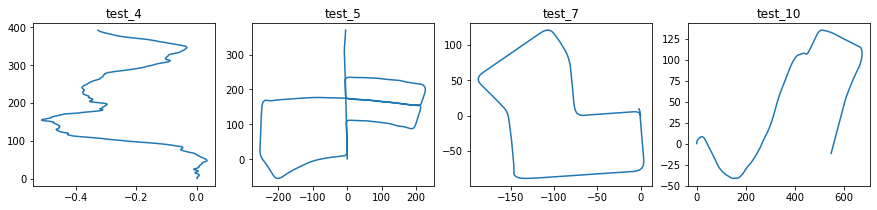

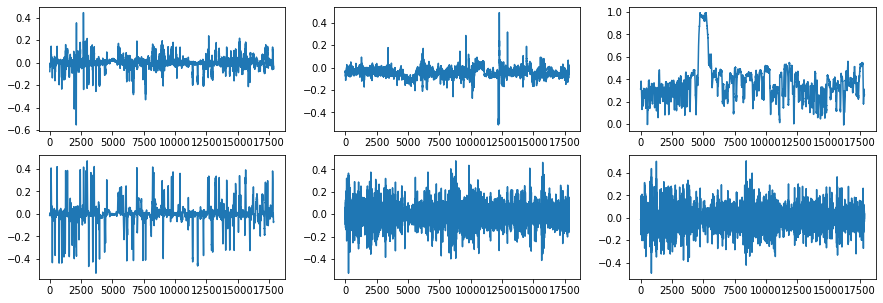

In [10]:
fig,axes=plt.subplots(nrows=1,ncols=len(test_files),figsize=(15,3))
for i,[kk,vv] in enumerate(test_indx.items()):
    abs_label=get_label_abs_pose(unscl_label(test_label[vv[0]:vv[1]]))
    axes[i].plot(abs_label[:,0],abs_label[:,2])
    axes[i].set_title('test_'+str(kk))

fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(15,5))
for i in range(no_of_pose):
    if time_step>2 :axes[i//3,i%3].plot(train_label[:,-1,i])
    else : axes[i//3,i%3].plot(train_label[: ,i])

### Generating train image path sequences

In [11]:
def get_image_paths(img_root1,_files,_overlap=1):
    img_data_a=[]
    img_data_b=[]
    img_root2='\\image_2\\*'
    for start_point in start_points:
        for i in _files:
           img_q=deque(maxlen=time_step)
           for path in glob.glob(img_root1+str(i).zfill(2)+img_root2)[start_point:-1]:
                    img_q.append(path)
                    if len(img_q)==time_step:
                       img_data_a.append(list(img_q))
                       img_q=deque(list(img_q)[-_overlap:],maxlen=time_step)
                       #for k in range(time_step-overlap):
                       #     del img_q[k]
    return np.array(img_data_a)
train_data=get_image_paths(img_root,train_files,_overlap=overlap)
val_data=get_image_paths(img_root,val_files,_overlap=overlap)
test_data=get_image_paths(img_root,test_files,_overlap=(time_step-1))

### Data Batch Generator

In [12]:
def resize_scl(image,scl):
    of_img=cv2.resize(image,(image_w//scl,image_h//scl))
    return of_img


def normalize_img(img):
    if _img_norm==True:
        mean = (-0.19007764876619865, -0.15170388157131237, -0.10659445665650864)
        std =  (0.2610784009469139, 0.25729316928935814, 0.25163823815039915)
        img[:,:,0]=(img[:,:,0]-mean[0])/std[0]
        img[:,:,1]=(img[:,:,1]-mean[1])/std[1]
        img[:,:,2]=(img[:,:,2]-mean[2])/std[2]
    
    return img.copy()
    
def batch_generator(_data,_label):
    no_of_batch=len(_data)//batch_size
    batch_index=np.arange(no_of_batch)
    if time_step>2 :
        batch_data_a=np.zeros((batch_size,image_h,image_w,3))
        batch_data_b=np.zeros((batch_size,image_h,image_w,3))
        batch_flow=np.zeros((batch_size,time_step-1,image_h//2,image_w//2,_flow_chanel))
    else:
        batch_data_a=np.zeros((batch_size,image_h,image_w,3))
        batch_data_b=np.zeros((batch_size,image_h,image_w,3))
        batch_flow_1=np.zeros((batch_size,image_h//_flow_scale,image_w//_flow_scale,_flow_chanel))
    
        batch_disp_1=np.zeros((batch_size,image_h//_disp_scale,image_w//_disp_scale,1))
        
    while(True):
        for ind in batch_index:#range(no_of_batch):
            k=0
            for j in range(ind*batch_size,(ind+1)*batch_size):
                imgs=[]
                for p,fname in enumerate(_data[j]):
                    img_a=cv2.imread(fname)
                    img_a=cv2.resize(img_a,(image_w,image_h))
                    imgs.append(img_a)
                    if p>0:
                                              
                        batch_data_a[k,:,:,:]=(imgs[p-1]/255.0)-_img_offset
                        batch_data_b[k,:,:,:]=(imgs[p]/255.0)-_img_offset
                
                k+=1
            batch_trans_label=np.array(_label[ind*batch_size:(ind+1)*batch_size,:3],dtype=np.float32)
            batch_rot_label=np.array(_label[ind*batch_size:(ind+1)*batch_size,3:],dtype=np.float32)
            yield ([batch_data_a,batch_data_b],[batch_trans_label,batch_rot_label])#,batch_flow_2,batch_flow_3,batch_flow_4,batch_flow_5])

In [13]:
train_batch = batch_generator(train_data,train_label)
val_batch   = batch_generator(val_data,val_label)
sample=next(train_batch)

for smp in sample[1]:
    print(smp.shape)


(16, 3)
(16, 3)


### Loss Functions and model defining

In [14]:
def custom_loss_trans(y_true,y_pred):
    abs_loss_trans=tf.reduce_mean(tf.abs(tf.subtract(y_true,y_pred)),axis=-1)
    if _pose_loss=='mae':
        loss_trans=tf.reduce_mean(tf.abs(tf.subtract(y_true,y_pred)),axis=-1)
    if _pose_loss=='mse':
        loss_trans=tf.reduce_mean(tf.square(tf.subtract(y_true,y_pred)),axis=-1)
    if _pose_loss=='rmse':
        loss_trans=tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true,y_pred)),axis=-1))
    return loss_trans,abs_loss_trans

def custom_loss_rot(y_true,y_pred):
    abs_loss_rot=tf.reduce_mean(tf.abs(tf.subtract(y_true,y_pred)),axis=-1)
    if _pose_loss=='mae':
        loss_rot=tf.reduce_mean(tf.abs(tf.subtract(y_true,y_pred)),axis=-1)
    if _pose_loss=='mse':
        loss_rot=tf.reduce_mean(tf.square(tf.subtract(y_true,y_pred)),axis=-1)
    if _pose_loss=='rmse':
        loss_rot=tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true,y_pred)),axis=-1))
    return loss_rot,abs_loss_rot

N=64//scale
  
    
def ConvNet(x,classes=3,i=''):
    _convs=[]
    _par=_net_par
    for i in range(_par._num_shared_layer):
        _name='block_'+str(_par._block[i])+'_conv_'+str(_par._nconv[i])
        x = Conv2D(_par._filters[i], (_par._kernels[i], _par._kernels[i]), padding='same',strides=_par._strides[i],kernel_regularizer=_par._kernel_regularizer,kernel_initializer=_par._kernel_initializer, name=_name)(x)
        if _par._batch_norm[i]: x = BatchNormalization()(x)
        if _par._act[i]==1:  
                          if _par._leaky_relu==True: x = LeakyReLU(alpha=0.1)(x)
                          if _par._relu==True: x = ReLU()(x)
        if _par._drop_out[i]>0.0 : x = Dropout(_par._drop_out[i],seed=_par.drop_seed)(x)
        if _par._nconv[i]==2 or _par._block[i]==2: _convs.append(x)
    _conv_flow=x
    _conv_disp=x
    x = Flatten()(x)
    
    return x


def PRF_NET(input_shape=(224,224,2)):
    _input_a=Input(shape=input_shape)
    _input_b=Input(shape=input_shape) 
    _input=concatenate([_input_a,_input_b],axis=3)
    x=ConvNet(_input,i=0)
    _par=_net_par
    
    trans=x
    for i in range(_par._num_trans_layers):
       trans = Dense(_par._trans_layer_nodes[i],kernel_regularizer=_par._kernel_regularizer, name='dense_1.'+str(i+1))(trans)
       if _par._trans_act[i]==1 :
                  if _par._relu==True: trans = ReLU()(trans)
                  if _par._leaky_relu==True: trans = LeakyReLU(alpha=0.1)(trans)
       if _par._trans_drop_out[i]>0.0 : trans = Dropout(_par._drop_out[i],seed=_par.drop_seed)(trans)

    trans = Dense(no_of_pose//2,kernel_regularizer=_par._kernel_regularizer, name='trans')(trans)

    rot=x
    for i in range(_par._num_rot_layers):
       rot = Dense(_par._rot_layer_nodes[i],kernel_regularizer=_par._kernel_regularizer, name='dense_2.'+str(i+1))(rot)
       if _par._rot_act[i]==1:
                         if _par._relu==True: rot = ReLU()(rot)
                         if _par._leaky_relu==True: rot = LeakyReLU(alpha=0.1)(rot)
       if _par._rot_drop_out[i]>0.0 : rot = Dropout(_par._drop_out[i],seed=_par.drop_seed)(rot)

    rot = Dense(no_of_pose//2,kernel_regularizer=_par._kernel_regularizer, name='rot')(rot)
    
    model = Model([_input_a,_input_b], [trans,rot], name='network')
    model.summary()
    return model

model = PRF_NET(input_shape=[image_h, image_w,3])

Model: "network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 320, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 320, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 320, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
block_1_conv_1 (Conv2D)         (None, 64, 160, 32)  9440        concatenate[0][0]          

In [15]:
model.load_weights(best_wts_path,by_name=True,skip_mismatch=True)
_=model.predict(sample[0])

In [16]:
batch_size=1
_data=batch_generator(train_data,train_label)
_times=[]
for i in trange(100):
    sample=next(_data)
    in_time=time.time()
    ret=model.predict(sample[0])
    final_time=time.time()-in_time
    _times.append(final_time)
    #print(final_time)
times=np.array(_times)
print("Inference time for one sample: ",times.mean()," seconds")


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.94it/s]

Inference time for one sample:  0.03142109394073486  seconds


In [17]:
from tqdm import trange
batch_size=16
_data=batch_generator(train_data,train_label)
tR=np.zeros((1,no_of_pose))
tS=np.zeros((1,no_of_pose))
for i in trange(len(train_data)//batch_size):
    sample=next(_data)
    ret=model.predict(sample[0])
    _ret=np.concatenate(ret[0:2],axis=1)
    _sample=np.concatenate(sample[1][0:2],axis=1)
    tR=np.concatenate((tR,_ret[:,:]),axis=0)
    tS=np.concatenate((tS,_sample[:,:]),axis=0)

100%|██████████████████████████████████████████████████████████████████████████████| 1115/1115 [08:14<00:00,  2.25it/s]


In [18]:
_tS=unscl_label(tS)
_tR=unscl_label(tR)

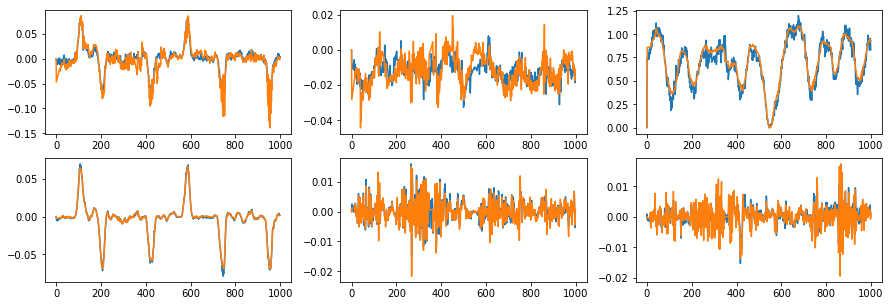

In [19]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(15,5))
for i in range(no_of_pose):
    axes[i//3,i%3].plot(_tR[:1000,i])
#fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(15,5))
for i in range(no_of_pose):
    axes[i//3,i%3].plot(_tS[:1000,i])

In [20]:
from tqdm import trange
batch_size=16
_data=batch_generator(test_data,test_label)
R=np.zeros((1,no_of_pose))
S=np.zeros((1,no_of_pose))
for i in trange(len(test_data)//batch_size):
    sample=next(_data)
    ret=model.predict(sample[0])
    _ret=np.concatenate(ret[0:2],axis=1)
    _sample=np.concatenate(sample[1][0:2],axis=1)
     
    R=np.concatenate((R,_ret[:,:]),axis=0)
    S=np.concatenate((S,_sample[:,:]),axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 332/332 [02:25<00:00,  2.28it/s]


In [21]:
_S=unscl_label(S)
_R=unscl_label(R)

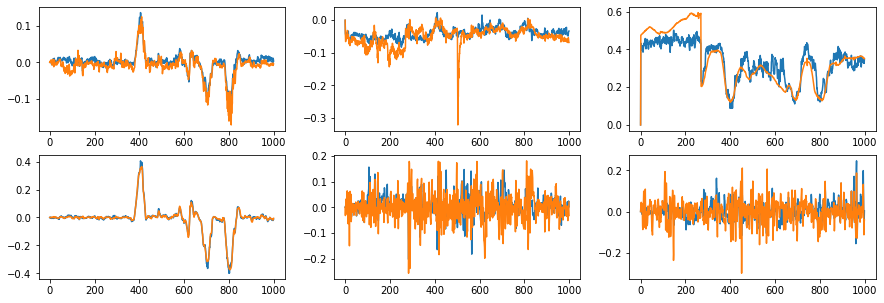

In [22]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(15,5))
for i in range(no_of_pose):
    axes[i//3,i%3].plot(R[:1000,i])
#fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(15,5))
for i in range(no_of_pose):
    axes[i//3,i%3].plot(S[:1000,i])

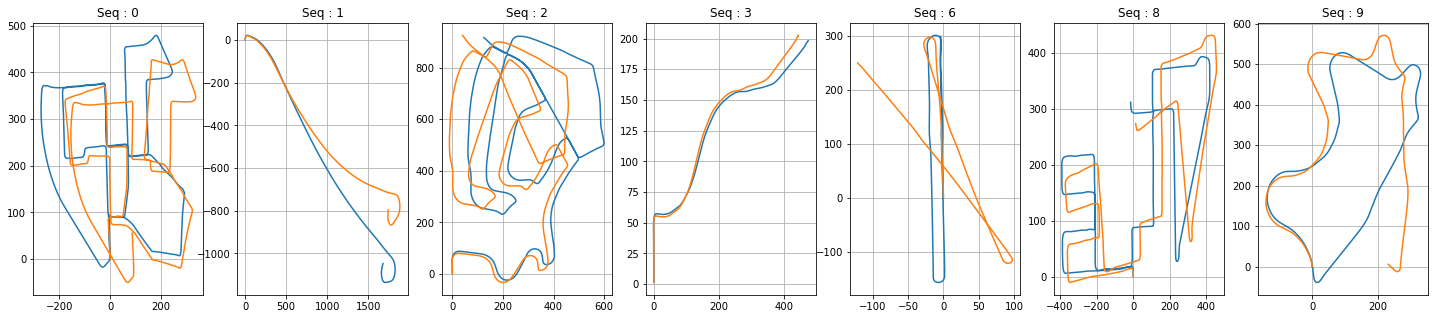

In [23]:
offset=train_indx[0][0]
_fig,_axes=plt.subplots(nrows=1,ncols=len(train_files),figsize=(25,5))

for j,i in enumerate(train_files):
    start=train_indx[i][0]-offset
    end=train_indx[i][1]-offset
    gt_abs_label=get_label_abs_pose(_tS[start:end])
    pd_abs_label=get_label_abs_pose(_tR[start:end])
    _axes[j].set_title('Seq : '+str(i))
    _axes[j].plot(gt_abs_label[:,0],gt_abs_label[:,2])
    _axes[j].plot(pd_abs_label[:,0],pd_abs_label[:,2])
    _axes[j].grid(True)
plt.show()

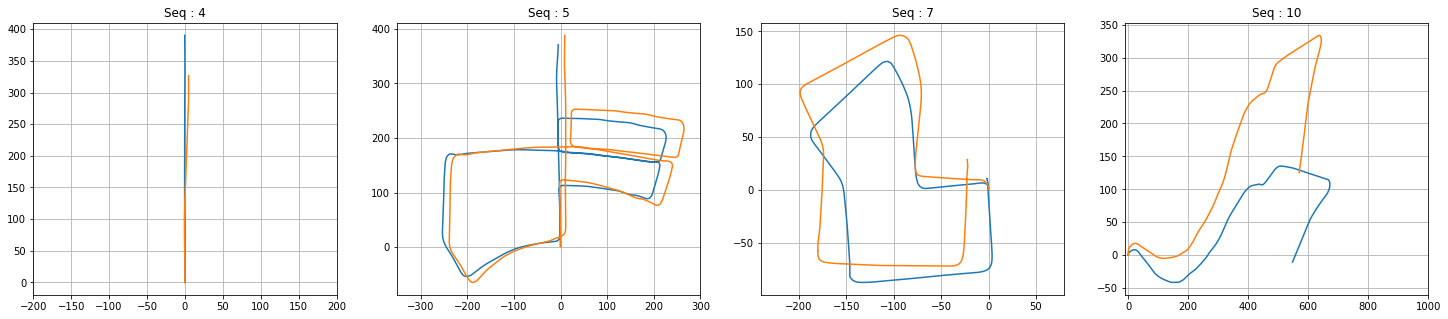

In [24]:
_fig,_axes=plt.subplots(nrows=1,ncols=len(test_files),figsize=(25,5))
for j,i in enumerate(test_files):
    start=test_indx[i][0]
    end=test_indx[i][1]
    gt_abs_label=get_label_abs_pose(_S[start:end])
    pd_abs_label=get_label_abs_pose(_R[start:end])
    _axes[j].set_title('Seq : '+str(i))
    _axes[j].plot(gt_abs_label[:,0],gt_abs_label[:,2])
    _axes[j].plot(pd_abs_label[:,0],pd_abs_label[:,2])
    _axes[j].grid(True)
    if j==0: _axes[j].set_xlim(-200,200)
    if j==1: _axes[j].set_xlim(-350,300)
    if j==2: _axes[j].set_xlim(-240,80)
    if j==3: _axes[j].set_xlim(-10,1000)
plt.show()

In [25]:
def get_trans_matrix(__label):
    _label=__label.copy()
    cords=np.zeros((_label.shape[0],6))
    mats=np.zeros((_label.shape[0]-1,12))
    for i,label in enumerate(_label):
        if i==0 : cords[i]=label
        else:
            rot_mat=euler_to_matrix(cords[i-1,3],0,0,axes='syxz')[:3,:3]
            label[:3]=rot_mat.dot(label[:3])
            label+=cords[i-1]
            label[3] = (label[3] + np.pi) % (2 * np.pi) - np.pi
            #label[3] = label[3] % (2*np.pi)
            mats[i-1]=np.concatenate([rot_mat,cords[i-1][:3].reshape(3,1)],axis=1).flatten()
            cords[i]=label
    return mats.copy()

def write_in_file(data,fname):
    with open(fname,'w') as file:
         for mat in data:
                line=''
                for val in mat:
                    line+=str(val)+' '
                line+='\n'
                file.write(line)
                

vi=list(test_indx.values())
files=list(test_indx.keys())
if not os.path.exists('result/submission/'): os.makedirs('result/submission/')
t_err_df={}
r_err_df={}
for i,[start,end] in enumerate(vi):
        pd_matrix=get_trans_matrix(_R[start:end])
        write_in_file(pd_matrix,'result/submission/'+str(files[i]).zfill(2)+'_pred.txt')

### Evaluation Code

1. Python implementation of official KITTI evaluation kit for visual odometry, official c++ code can be found here https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_odometry.zip

2. Keep the ground truth poses in the following location: 'result/ground truth'

In [26]:
class Eval_Kitti_Odom():
    def __init__(self):
        
        self.lengths = [100,200,300,400,500,600,700,800]
        self.num_lengths = len(self.lengths)
        self.gt_dir='result/ground truth'
        self.result_dir='result/submission/'
        self.eval_seqs = ['04','05','07','10']
        
        gt_files = glob.glob(self.gt_dir + '/*.txt')
        gt_files = [os.path.split(f)[1] for f in gt_files]
        self.seqs_with_gt = [os.path.splitext(f)[0] for f in gt_files]
    
    def load_poses(self, file_name):
        poses = {}
        frame_index = 0
        with open(file_name, 'r') as file:
            data = file.readlines()
            
        file_len = len(data)
        for ind, line in enumerate(data):
            mat = np.eye(4)
            line_split = [float(i) for i in line.split()]
            for row in range(3):
                for col in range(4):
                    mat[row, col] = line_split[row*4 + col]
            
            frame_index = ind
            poses[frame_index] = mat
        return poses

    def calc_traj_distances(self, poses):
        dist = [0]
        frame_index = sorted(poses.keys())
        for i in range(len(frame_index)-1):
            curr_frame_index = frame_index[i]
            next_frame_index = frame_index[i+1]
            cf_pos = poses[curr_frame_index]
            nf_pos = poses[next_frame_index]
            dx = cf_pos[0,3] - nf_pos[0,3]
            dy = cf_pos[1,3] - nf_pos[1,3]
            dz = cf_pos[2,3] - nf_pos[2,3]
            dist.append(dist[i]+np.sqrt(dx**2+dy**2+dz**2))    
        self.distance = dist[-1]
        return dist

    def calc_rotation_error(self, pose_error):
        a = pose_error[0,0]
        b = pose_error[1,1]
        c = pose_error[2,2]
        d = 0.5*(a+b+c-1.0)
        return np.arccos(max(min(d,1.0),-1.0))

    def calc_trans_error(self, pose_error):
        dx = pose_error[0,3]
        dy = pose_error[1,3]
        dz = pose_error[2,3]
        return np.sqrt(dx**2+dy**2+dz**2)
        
    def calc_seq_errors(self, poses_gt, poses_result):
        errors = []
        self.max_speed = 0
        dist = self.calc_traj_distances(poses_gt)
        self.step_size = 10
        
        for first_frame in range(0, len(poses_gt), self.step_size):
            
            for i in range(self.num_lengths):
                seq_length = self.lengths[i]
                
                last_frame=-1
                for ind in range(first_frame, len(dist), 1):
                    if dist[ind] > (dist[first_frame] + seq_length):
                        last_frame = ind
                        break
                
                if last_frame == -1 or not(last_frame in poses_result.keys()) or not(first_frame in poses_result.keys()):
                    continue
                
                delta_gt = np.dot(np.linalg.inv(poses_gt[first_frame]), poses_gt[last_frame])
                delta_result = np.dot(np.linalg.inv(poses_result[first_frame]), poses_result[last_frame])
                pose_error = np.dot(np.linalg.inv(delta_result),delta_gt)
                    
                r_err = self.calc_rotation_error(pose_error)
                t_err = self.calc_trans_error(pose_error)

                num_frames = last_frame - first_frame + 1.0
                speed = seq_length / (0.1*num_frames)
                if speed > self.max_speed:
                    self.max_speed = speed
                errors.append([first_frame, r_err/seq_length, t_err/seq_length, seq_length, speed])
        return errors
        
    def calc_avg_err(self, seq_err):
        trans_err = 0
        rot_err = 0
        seq_len = len(seq_err)

        for err in seq_err:
            rot_err += err[1]
            trans_err += err[2]
        ave_trans_err = trans_err / seq_len
        ave_rot_err = rot_err / seq_len
        return ave_trans_err, ave_rot_err 

    def evaluate(self):
        eval_dir = self.result_dir
        if not os.path.exists(eval_dir): os.makedirs(eval_dir)

        avt_errs = {}    
        avr_errs = {}    
        for seq in self.eval_seqs:
            pred_file_name = self.result_dir + '/{}_pred.txt'.format(seq)
            gt_file_name   = self.gt_dir + '/{}.txt'.format(seq)
            
            poses_result = self.load_poses(pred_file_name)
            poses_gt = self.load_poses(gt_file_name)
            
            seq_err = self.calc_seq_errors(poses_gt, poses_result)
            ave_t_err, ave_r_err = self.calc_avg_err(seq_err)
            
            avt_errs[seq] = ave_t_err*100
            avr_errs[seq] = (ave_r_err/np.pi*180)*100
        
        return avt_errs,avr_errs


In [27]:
kitti_eval=Eval_Kitti_Odom()
t_err,r_err=kitti_eval.evaluate()
print('Translation Error %: ')
print(pd.DataFrame(t_err,index=['']))
print('\nRotation Error deg/100m:')
print(pd.DataFrame(r_err,index=['']))

Translation Error %: 
         04        05        07         10
  15.318015  6.900808  6.911419  11.602502

Rotation Error deg/100m:
        04        05        07        10
  1.127778  1.498192  2.516451  3.470983


In [28]:
### END